# Определение стоимости автомобилей

## Описание проекта

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение, которое позволит привлечь новых клиентов, предоставляя им возможность узнать рыночную стоимость своего автомобиля. Для достижения этой цели мы строим модель, которая способна определять рыночную стоимость автомобилей на основе данных о их технических характеристиках, комплектации и ценах других автомобилей.

Критерии важные для заказчика:

1. Качество предсказания: Мы стремимся к высокому качеству предсказания, чтобы наши клиенты могли получить точную оценку рыночной стоимости своего автомобиля. Для этого мы используем современные алгоритмы машинного обучения, которые обеспечивают высокую точность предсказаний.

2. Время обучения модели: Мы понимаем, что заказчику важно, чтобы модель обучалась быстро, чтобы мы могли быстро внедрить изменения и улучшения. Поэтому мы используем эффективные методы обучения модели, которые позволяют нам значительно сократить время обучения.

3. Время предсказания модели: Мы придаем большое значение быстроте предсказания модели, чтобы наши клиенты могли мгновенно получить оценку стоимости своего автомобиля. Мы оптимизируем процессы предсказания и используем оптимизированные алгоритмы, чтобы обеспечить максимальную скорость работы модели.

Наша команда разработки поставила перед собой задачу создать эффективную модель, которая сочетает в себе высокое качество предсказания, быстрое время обучения и минимальное время предсказания. Мы уверены, что наше приложение сможет привлечь новых клиентов и удовлетворить потребности уже существующих, предоставляя им доступ к точной и актуальной информации о рыночной стоимости их автомобилей.

## Описание данных

**Признаки**
* DateCrawled — дата скачивания анкеты из базы
* VehicleType — тип автомобильного кузова
* RegistrationYear — год регистрации автомобиля
* Gearbox — тип коробки передач
* Power — мощность (л. с.)
* Model — модель автомобиля
* Kilometer — пробег (км)
* RegistrationMonth — месяц регистрации автомобиля
* FuelType — тип топлива
* Brand — марка автомобиля
* Repaired — была машина в ремонте или нет
* DateCreated — дата создания анкеты
* NumberOfPictures — количество фотографий автомобиля
* PostalCode — почтовый индекс владельца анкеты (пользователя)
* LastSeen — дата последней активности пользователя

**Целевой признак**
* Price — цена (евро)

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import lightgbm as lgb


sns.set_style("darkgrid")
TARGET = 'price'
RANDOM_SEED = np.random.RandomState(5081997)
RANDOM_SEED_INT = 5081997

## Анализ исходных данных

In [2]:
try:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')
except:
    data = pd.read_csv('autos.csv')

In [3]:
# сразу скорректируем названия столбцов
data.columns = data.columns.str.replace(r"([A-Z])", r" \1", regex=True).str[1:].str.lower().str.replace(' ', '_')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354369 non-null  object
 1   price               354369 non-null  int64 
 2   vehicle_type        316879 non-null  object
 3   registration_year   354369 non-null  int64 
 4   gearbox             334536 non-null  object
 5   power               354369 non-null  int64 
 6   model               334664 non-null  object
 7   kilometer           354369 non-null  int64 
 8   registration_month  354369 non-null  int64 
 9   fuel_type           321474 non-null  object
 10  brand               354369 non-null  object
 11  repaired            283215 non-null  object
 12  date_created        354369 non-null  object
 13  number_of_pictures  354369 non-null  int64 
 14  postal_code         354369 non-null  int64 
 15  last_seen           354369 non-null  object
dtypes:

In [5]:
def show_info(data: pd.DataFrame):
    display(data.describe())
    print('Процент пропущенных значений:')
    display((data.isna().sum()/len(data)*100).sort_values(ascending=False).head(10))

In [6]:
show_info(data)

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Процент пропущенных значений:


repaired             20.079070
vehicle_type         10.579368
fuel_type             9.282697
gearbox               5.596709
model                 5.560588
date_crawled          0.000000
price                 0.000000
registration_year     0.000000
power                 0.000000
kilometer             0.000000
dtype: float64

Пропущенные значения встречаются в 5 характеристиках автомобилей таких как:
* Repaired — была машина в ремонте или нет
* VehicleType — тип автомобильного кузова
* FuelType — тип топлива
* Gearbox — тип коробки передач
* Model — модель автомобиля

Посмотрим их и обработаем

Удалим лишние факторы

In [7]:
data = data.drop(['date_crawled', 'date_created', 'number_of_pictures', 'postal_code', 'last_seen'],
                 axis=1)

## Предобработка данных

### Удаление пропусков и обработка анамольных значений
#### vehicle_type — тип автомобильного кузова

In [8]:
data['vehicle_type'].value_counts(dropna=False)

sedan          91457
small          79831
wagon          65166
NaN            37490
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: vehicle_type, dtype: int64

Сгруппируем по бренду и модели, чтобы приблизительно определить тип кузова. Оставшиеся пустые значения отнесем в категорию "other"

In [9]:
# получим моды для группировки по бренду и модели
mode_values = data.groupby(['brand', 'model'])['vehicle_type'].apply(lambda x: x.mode()[0]).reset_index()
# добавим столбец к общему датафрейму
data = data.merge(mode_values, on=['brand', 'model'], how='left', suffixes=('', '_mode'))
# заменим пустые значения
data['vehicle_type'] = data['vehicle_type'].fillna(data['vehicle_type_mode'])
# удалим вспомогательный столбец
data = data.drop(columns=['vehicle_type_mode'])
# заполним оставшиеся пустые значения на other
data['vehicle_type'] = data['vehicle_type'].fillna('other')

#### registration_year — год регистрации автомобиля

In [10]:
print(sorted(data['registration_year'].unique()))

[1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500, 1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000, 3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555, 5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200, 8455, 8500, 8888, 9000, 9229, 9450, 9996, 9999]


В данном факторе просто удалим автомобили, у которых значение года регистрации <1910 и >2019, вероятно, что знаечния которые соответствуют заданным условиям являются выбросами

*1910 год выбран, поскольку в автомобилестроении с середины 1910-х годов получила самое широкое распространение конвейерная система сборки, революционизировавшая индустрию XX века.*

In [11]:
data = data[(data['registration_year']>=1910)&(data['registration_year']<=2019)].reset_index(drop=True)

#### gearbox — тип коробки передач

In [12]:
data['gearbox'].value_counts(dropna=False)

manual    268225
auto       66278
NaN        19695
Name: gearbox, dtype: int64

Заполним пустые значения в типе коробки передач с помощью "unknown"

In [13]:
data['gearbox'] = data['gearbox'].fillna('unknown')

#### power — мощность (л. с.)

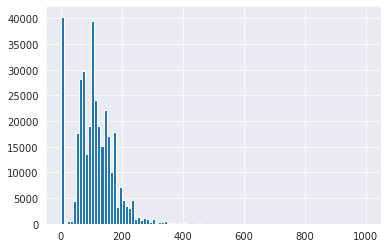

In [14]:
data[data['power']<1000]['power'].hist(bins=100)
plt.show()

In [15]:
# выделим автомобили меньше 1000 л.с.
data = data[data['power']<1000].reset_index(drop=True)

# 0 л.с. заменим медианной группируя по бренду, модели и году регистрации
median_values = data[data['power']>0].groupby(
    ['brand', 'model', 'registration_year'])['power'].apply(lambda x: x.median()).reset_index()

data = data.merge(median_values, on=['brand', 'model', 'registration_year'], how='left', suffixes=('', '_median'))

# заменим 0 на медиану из median_values
mask = data['power'] == 0
data.loc[mask, 'power'] = data.loc[mask, 'power_median']
data = data.drop(columns=['power_median'])

# заполним оставшиеся пустые значения на медиану
data['power'] = data['power'].fillna(data['power'].median())

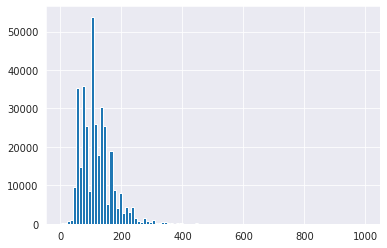

In [16]:
data['power'].hist(bins=100)
plt.show()

#### model — модель автомобиля

In [17]:
data['model'].value_counts(dropna=False).head(10)

golf        29203
other       24390
3er         19741
NaN         19595
polo        13051
corsa       12555
astra       10795
passat      10133
a4           9894
c_klasse     8305
Name: model, dtype: int64

In [18]:
# заменим пропуки на other
data['model'] = data['model'].fillna('other')

#### kilometer — пробег (км)

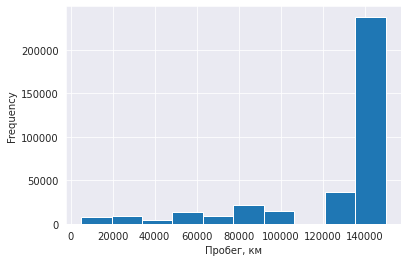

In [19]:
data['kilometer'].plot(kind='hist')
plt.xlabel('Пробег, км')
plt.show()

#### registration_month — месяц регистрации автомобиля

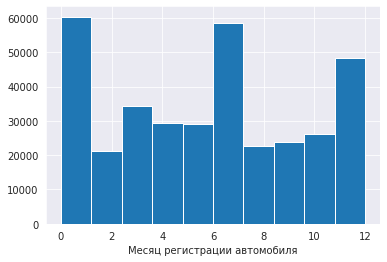

In [20]:
data['registration_month'].hist()
plt.xlabel('Месяц регистрации автомобиля')
plt.show()

Данный признак не требует изменений и, вероятно, его можно удалить, но пока оставим и посмотрим в дальнейшем на качество моделей с данным признаком и без

#### fuel_type — тип топлива

In [21]:
data['fuel_type'].value_counts()

petrol      216153
gasoline     98640
lpg           5307
cng            562
hybrid         233
other          202
electric        90
Name: fuel_type, dtype: int64

**petrol** и **gasoline** на самом деле одно и то же; просто разные слова. Эти два слова имеют одинаковое значение, с той лишь разницей, что они используются в тех местах, где они используются. Термин «petrol» используется в Великобритании, Индии и некоторых других странах, тогда как «gasoline» используется в Соединенных Штатах

In [22]:
# заменим gasoline на petrol
data['fuel_type'] = data['fuel_type'].apply(lambda x: x.replace('gasoline', 'petrol') if not pd.isna(x) else x)

Пропуски заполним модой (petrol)

In [23]:
data['fuel_type'] = data['fuel_type'].fillna('diesel')

#### brand — марка автомобиля

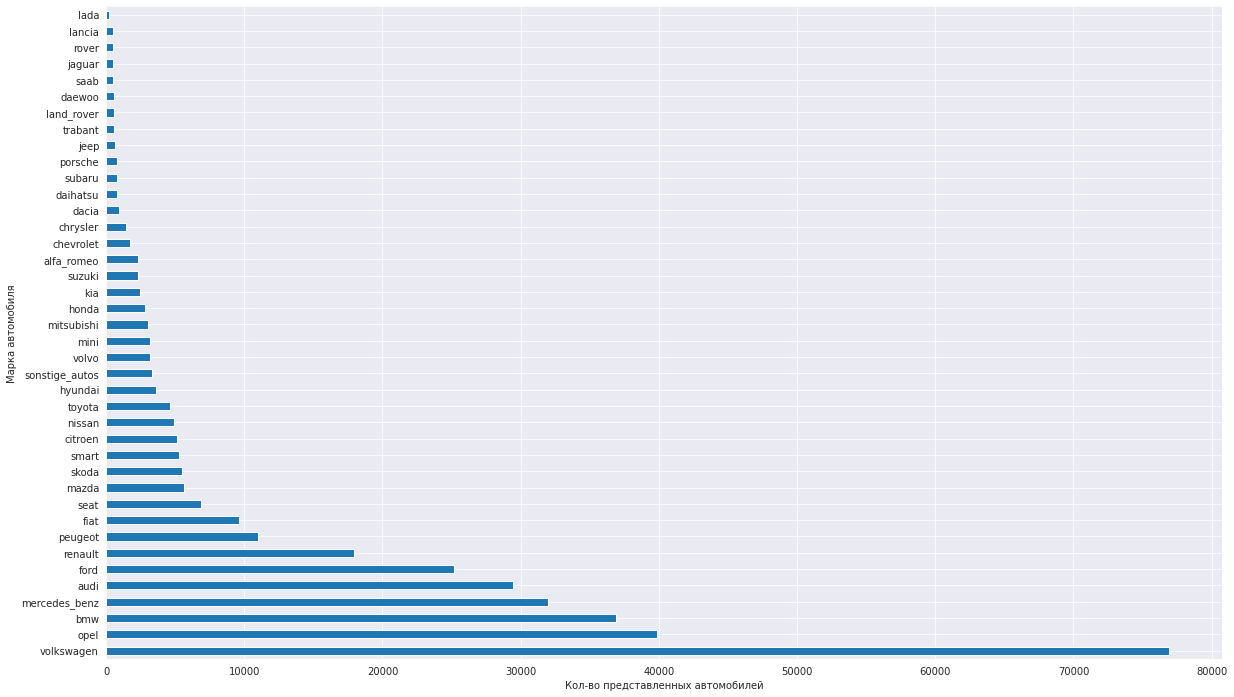

In [24]:
data['brand'].value_counts().plot(kind='barh', figsize=(20,12))
plt.xlabel('Кол-во представленных автомобилей')
plt.ylabel('Марка автомобиля')
plt.show()

Данный признак также не требует изменений

#### repaired — была машина в ремонте или нет

В данном признаке пропуски могут обозначать то, что автомобиль не был в ремонте - заменим пропуски на no

In [25]:
data['repaired'] = data['repaired'].fillna('no')

#### price - цена (целевой признак)

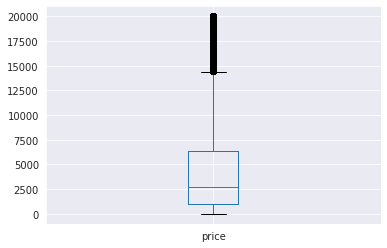

In [26]:
data['price'].plot(kind='box')
plt.show()

In [27]:
def outliers(array):
    q25=np.array(array.quantile(0.25))
    q75=np.array(array.quantile(0.75))
    first_part=q25-1.5*(q75-q25)
    second_part=q75+1.5*(q75-q25)
    return first_part, second_part

first_part, second_part = outliers(data['price'])

Удалим значения цен больше 14425

In [28]:
data = data[(data['price']>=first_part)&(data['price']<=second_part)]
data = data[data['price']>0]

### Дублкаты

In [29]:
print('Явных дубликатов:', data.duplicated().sum())

Явных дубликатов: 28941


In [30]:
# удалим дубликаты
data = data.drop_duplicates().reset_index(drop=True)

В данном разделе был проведен анализ признаков, корректировка их ананомальных значений и заполнение пропусков. Также были удалены дублирующие наблюдения и лишние признаки. Таким образом, данные подготовлены к их дальнейшему преобразованию для моделей.

## Подготовка выборок и их преобразование

In [31]:
categories = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [32]:
X = data.drop(columns=TARGET)
y = data[TARGET]
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=RANDOM_SEED)
# X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.4, random_state=RANDOM_SEED)

In [33]:
# Разделение на обучающую и временную выборки
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_SEED)

# разделение временной выборки на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_trainval, y_trainval, test_size=0.33, random_state=RANDOM_SEED)

In [34]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=999)

encoder.fit(X_train[categories])

X_train = X_train.copy()
X_valid = X_valid.copy()
X_test = X_test.copy()
    
X_train.loc[:, categories] = encoder.transform(X_train[categories])
X_valid.loc[:, categories] = encoder.transform(X_valid[categories])
X_test.loc[:, categories] = encoder.transform(X_test[categories])

In [35]:
# encoder = LabelEncoder()

# for factor in categories:
#     encoder.fit(X_train[factor])
#     X_train = X_train.copy()
#     X_test = X_test.copy()
#     X_train.loc[:, factor] = encoder.transform(X_train[factor])
#     X_test.loc[:, factor] = encoder.transform(X_test[factor])

Данные разбиты на обучающую и тестовую выборки, а также признаки закодированы для дальнейшего обучения моделей

## Обучение моделей

В данном разделе обучим 3 модели: CatBoost, RandomForest и LightGBM. Затем сравним их по следующим параметрам:

* время обучения модели
* время предсказания
* качество прдесказаний (метрика - RMSE)

### catboost

In [36]:
catboost_model = CatBoostRegressor(iterations=1000,
                                  loss_function='RMSE',
                                  verbose=50)

In [37]:
%%time
# parameters_cat = {'depth': [5, 10], 'learning_rate': np.arange(0.1, 1)}
# catboost_model = catboost_model.grid_search(parameters_cat,
#             Pool(X_train, y_train, cat_features=categories),
#             cv=3,
#             verbose=50,
#             plot=False)

#catboost_model['params']

#output
#{'depth': 10, 'learning_rate': 0.1}

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [38]:
%%time
catboost_model = CatBoostRegressor(loss_function='RMSE',
                                   depth=10,
                                   learning_rate=0.1,
                                   verbose=50,
                                   random_seed=RANDOM_SEED_INT)
catboost_model.fit(X_train, y_train)

0:	learn: 3238.2364930	total: 93.2ms	remaining: 1m 33s
50:	learn: 1528.0130039	total: 2.18s	remaining: 40.5s
100:	learn: 1447.1548742	total: 4.16s	remaining: 37s
150:	learn: 1404.7981881	total: 6.13s	remaining: 34.5s
200:	learn: 1371.3649448	total: 8.14s	remaining: 32.4s
250:	learn: 1343.4850237	total: 10.2s	remaining: 30.6s
300:	learn: 1320.4632664	total: 12.3s	remaining: 28.6s
350:	learn: 1301.0681795	total: 14.5s	remaining: 26.7s
400:	learn: 1283.4212958	total: 16.5s	remaining: 24.6s
450:	learn: 1267.3767788	total: 18.5s	remaining: 22.5s
500:	learn: 1254.0194338	total: 20.4s	remaining: 20.3s
550:	learn: 1241.5964384	total: 22.4s	remaining: 18.3s
600:	learn: 1230.0597045	total: 24.4s	remaining: 16.2s
650:	learn: 1219.2946261	total: 26.3s	remaining: 14.1s
700:	learn: 1208.8007817	total: 28.3s	remaining: 12.1s
750:	learn: 1198.9793586	total: 30.3s	remaining: 10.1s
800:	learn: 1189.4837696	total: 32.3s	remaining: 8.04s
850:	learn: 1180.3545476	total: 34.3s	remaining: 6.01s
900:	learn: 1

In [39]:
%%time
print('Время предсказания модели:')
catboost_pred = catboost_model.predict(X_valid)

Время предсказания модели:
CPU times: user 324 ms, sys: 0 ns, total: 324 ms
Wall time: 329 ms


In [40]:
catboost_pred = [x if x>0 else 0 for x in catboost_pred]
catboost_rmse = mean_squared_error(y_valid, catboost_pred, squared=False)
print('RMSE на тестовой выборке (CatBoost):', catboost_rmse)

RMSE на тестовой выборке (CatBoost): 1407.9108978705808


### RandomForest

In [41]:
%%time
rf_model = RandomForestRegressor(criterion='mse',
                                 random_state=RANDOM_SEED,
                                 n_estimators = 100,
                                 n_jobs=-1)
rf_model.fit(X_train, y_train)

CPU times: user 39.5 s, sys: 632 ms, total: 40.2 s
Wall time: 40.3 s


RandomForestRegressor(n_jobs=-1,
                      random_state=RandomState(MT19937) at 0x7F093BB5C140)

In [42]:
%%time
print('Время предсказания модели:')
rf_pred = rf_model.predict(X_valid)

Время предсказания модели:
CPU times: user 2.86 s, sys: 3.86 ms, total: 2.87 s
Wall time: 2.87 s


In [43]:
rf_pred = [x if x>0 else 0 for x in rf_pred]
rf_rmse = mean_squared_error(y_valid, rf_pred, squared=False)
print('RMSE на тестовой выборке (RandomForest):', rf_rmse)

RMSE на тестовой выборке (RandomForest): 1490.913739051489


### LightGBM

In [44]:
%%time
train_data = lgb.Dataset(X_train, label=y_train)

# params = {
#     'objective': 'regression',
#     'metric': 'rmse',
#     'boosting_type': 'gbdt',
#     'learning_rate': 0.1,
#     'num_boost_round': 100
# }

# param_grid = {
#     'max_depth': [5, 10, 15],
#     'min_child_samples': [10, 20, 30],
#     'subsample': [0.8, 0.9, 1.0],
#     'colsample_bytree': [0.8, 0.9, 1.0]
# }

# lgb_model = lgb.LGBMRegressor()

# random_search = RandomizedSearchCV(lgb_model,
#                                    param_distributions=param_grid,
#                                    n_iter=10, scoring='neg_root_mean_squared_error',
#                                    cv=3, verbose=1)

# # обучение модели с подобранными гиперпараметрами
# random_search.fit(X_train, y_train)

# # получение лучших гиперпараметров
# best_params = random_search.best_params_

# # обновление параметров модели с лучшими гиперпараметрами
# params.update(best_params)

CPU times: user 25 µs, sys: 1e+03 ns, total: 26 µs
Wall time: 29.1 µs


In [45]:
%%time
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'num_boost_round': 100,
    'subsample': 0.8,
    'min_child_samples': 10,
    'max_depth': 10,
    'colsample_bytree': 0.8
}

lgb_model = lgb.LGBMRegressor(random_state=RANDOM_SEED)
# обучение модели с обновленными гиперпараметрами
lgb_model = lgb.train(params, train_data, num_boost_round=params['num_boost_round'])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:177: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092129 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 148369, number of used features: 10
[LightGBM] [Info] Start training from score 3829.806597
CPU times: user 3.28 s, sys: 52.8 ms, total: 3.34 s
Wall time: 3.29 s


In [46]:
%%time
print('Время предсказания модели:')
lgb_pred = lgb_model.predict(X_valid)

Время предсказания модели:
CPU times: user 527 ms, sys: 0 ns, total: 527 ms
Wall time: 504 ms


In [47]:
lgb_pred = [x if x>0 else 0 for x in lgb_pred]
lgb_rmse = mean_squared_error(y_valid, lgb_pred, squared=False)
print('RMSE на тестовой выборке (RandomForest):', lgb_rmse)

RMSE на тестовой выборке (RandomForest): 1492.857964778505


В данном разделе были обучены модели CatBoost, RandomForest и LightGBM а также выведена их скорость обучения, таким образом далее мы сможем оценить какая из моделей в совокупности факторов является наиболее подходящей

## Анализ моделей и тестирование

In [50]:
# %%time
# lgb_pred = [x if x>0 else 0 for x in lgb_model.predict(X_test)]
# lgb_rmse = mean_squared_error(y_test, lgb_pred, squared=False)
# print('RMSE на тестовой выборке (LightGBM):', lgb_rmse)

Оценим наши модели по кретериям заказчика: качество предсказаний, время обучения модели и время предсказания модели

**1. Качество модели на валидационной выборке (метрика RMSE)**

<p>CatBoost - 1407</p>
<p>RandomForest - 1490</p>
<p>LightGBM - 1492</p>

**2. Скорость обучения моделей**

<p>CatBoost - 42.4 s</p>
<p>RandomForest - 41.3 s</p>
<p>LightGBM - 9.36 s</p>

**3. Скорость предсказания моделей**

<p>CatBoost - 318 ms</p>
<p>RandomForest - 3.14 s</p>
<p>LightGBM - 497 ms</p>


Наилучшее качество показала модель catboost, однако скорость обучения у данной модели наибольшее (42 секунды). Время предсказания около 300 милисекунд, что достаточно быстро. Таким образом, если нет необходимости слишком часто обучать модель заново, то модель catboost является наилучшей. Оценим ее качество на тестовой выборке.

In [51]:
%%time
catboost_pred_test = [x if x>0 else 0 for x in catboost_model.predict(X_test)]
catboost_rmse_test = mean_squared_error(y_test, catboost_pred_test, squared=False)
print('RMSE на тестовой выборке (CatBoost):', catboost_rmse_test)

RMSE на тестовой выборке (CatBoost): 1382.9159403146055
CPU times: user 306 ms, sys: 110 µs, total: 306 ms
Wall time: 305 ms


Время предсказания совпадает, а качество на тестовой выборке даже немного лучше. Обучим модель catboost на обучающей + валидационной выборке и оценим качество на тестовой выборке еще раз.

In [52]:
X_train_full = pd.concat([X_train, X_valid])
y_train_full = pd.concat([y_train, y_valid])

catboost_model = CatBoostRegressor(loss_function='RMSE',
                                   depth=10,
                                   learning_rate=0.1,
                                   verbose=50,
                                   random_seed=RANDOM_SEED_INT)

catboost_model.fit(X_train_full, y_train_full)

0:	learn: 3237.3596390	total: 57ms	remaining: 56.9s
50:	learn: 1537.4169159	total: 2.82s	remaining: 52.5s
100:	learn: 1459.7387264	total: 5.58s	remaining: 49.6s
150:	learn: 1420.1272473	total: 8.28s	remaining: 46.6s
200:	learn: 1391.4090587	total: 11.1s	remaining: 44.3s
250:	learn: 1368.8235931	total: 14s	remaining: 41.8s
300:	learn: 1350.3064435	total: 17s	remaining: 39.5s
350:	learn: 1333.6005883	total: 20s	remaining: 37.1s
400:	learn: 1318.4695178	total: 22.9s	remaining: 34.2s
450:	learn: 1305.3671492	total: 25.7s	remaining: 31.3s
500:	learn: 1292.5514796	total: 28.5s	remaining: 28.4s
550:	learn: 1281.6106705	total: 31.4s	remaining: 25.6s
600:	learn: 1272.0259480	total: 34.2s	remaining: 22.7s
650:	learn: 1261.5398759	total: 36.9s	remaining: 19.8s
700:	learn: 1251.9005228	total: 39.8s	remaining: 17s
750:	learn: 1242.3438385	total: 42.7s	remaining: 14.2s
800:	learn: 1233.5660845	total: 45.6s	remaining: 11.3s
850:	learn: 1225.8274269	total: 48.4s	remaining: 8.48s
900:	learn: 1217.81801

In [53]:
%%time
print('Время предсказания модели:')
catboost_pred_full = catboost_model.predict(X_test)

catboost_pred_full = [x if x>0 else 0 for x in catboost_pred_full]
catboost_rmse_full = mean_squared_error(y_test, catboost_pred_full, squared=False)
print('RMSE на тестовой выборке (CatBoost):', catboost_rmse_full)

Время предсказания модели:
RMSE на тестовой выборке (CatBoost): 1369.8985403661336
CPU times: user 307 ms, sys: 0 ns, total: 307 ms
Wall time: 312 ms


После обучения на полной выборке качество модели на тестовой выборке стало лучше